# Example: PyRayHF Generate Oblique Data
This is a modification of [`Example_PyRayHF_Cartesian_Gradient.ipynb`](./Example_PyRayHF_Cartesian_Gradient.ipynb) that simply demonstrates the process of ray tracing on input data obtained from PyIRI and generation of the oblique ionogram.

(see [`Example_Generate_2D_Input.ipynb`](./Example_Generate_2D_Input.ipynb) for generating PyIRI input data for PyRayHF)

1. Imports

In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import PyRayHF
from PyRayHF.library import trace_ray_spherical_snells
import time
from copy import deepcopy

2. Load Previously Generated EDP

ray_data_X
ray_data_O
tlat
tlon
rlat
rlon
edp
aalt
year
month
day
UT
F107


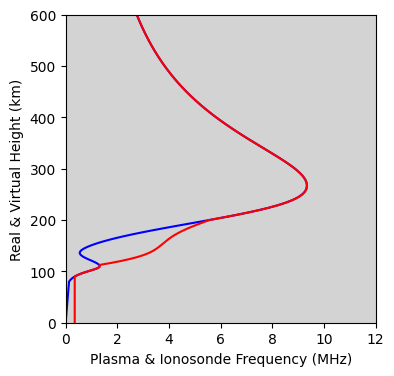

In [2]:
# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create input
# arrays using PyIRI.
file_open = 'MoJo_Data.p'
data = pickle.load(open(file_open, 'rb'))

file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

R_loc = 1000.

nrays = len(data['ray_data_X'])

af0_Hz = np.zeros(nrays) # Array of ray frequencies
P = np.zeros(nrays)
for i in range(nrays):
    af0_Hz[i] = data["ray_data_X"][i]["freq_Hz"]
    P[i] = data["ray_data_X"][i]["delay_km"]

alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)


for key in data:
    print(key)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 600])
ax.set_xlim([0, 12])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(data['edp']) / 1e6,
        data['aalt'], c='blue', label='Background', zorder=1)
ax.plot(PyRayHF.library.den2freq(Ne) / 1e6,
        alt_km, c='red', label='Background', zorder=1)


6. Plot oblique and vertical at midpoint

/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_22408/4238440867.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.94, 1])  # leave space for colorbar


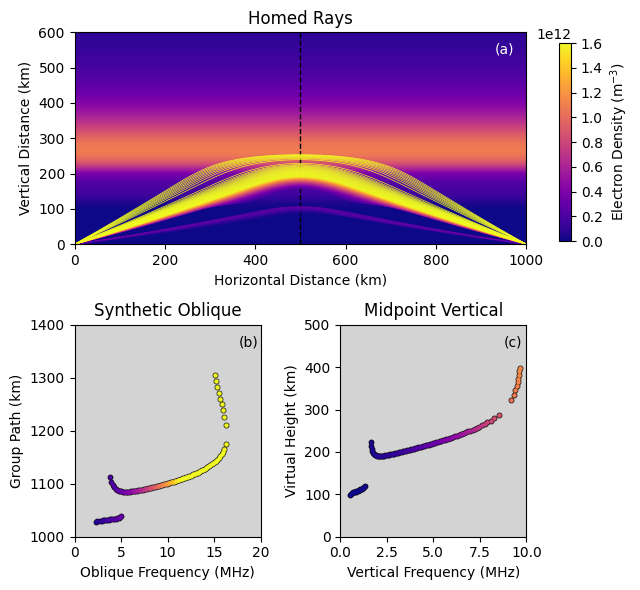

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np

fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_bot1 = fig.add_subplot(gs[1, 0])
ax_bot2 = fig.add_subplot(gs[1, 1])

# --- Top: Raytracing plot ------------------------------------------------
ax_plot = ax_top
ax_plot.set_xlim(0, 1000)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
ax_plot.set_title("Homed Rays")

vmin, vmax = 0, 1.6e12
nx = 500
xmax = 1000.
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
pc = ax_plot.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.axvline(x=R_loc / 2., linestyle='--', color='black', linewidth=1)

cmap = cm.plasma
norm = colors.Normalize(vmin=vmin, vmax=vmax)
af0_den = PyRayHF.library.freq2den(af0_Hz)

for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax_plot.plot(data['ray_data_X'][ifr]['x'][:], data['ray_data_X'][ifr]['z'][:], color=color, linewidth=0.5)
ax_plot.text(0.93, 0.95, '(a)', transform=ax_plot.transAxes,
             ha='left', va='top', c='white')

# --- Bottom left: Synthetic Oblique -------------------------------------
ax = ax_bot1
ax.set_title('Synthetic Oblique')
ax.set_facecolor('lightgray')
ax.set_ylabel('Group Path (km)')
ax.set_xlabel('Oblique Frequency (MHz)')
ax.set_xlim([0, 20])
ax.set_ylim([1000, 1400])
f = af0_Hz / 1e6
ax.scatter(f, P, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax.scatter(f[ifr], P[ifr], color=color, s=5)
ax.text(0.88, 0.95, '(b)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Bottom right: Midpoint Vertical ------------------------------------
ax = ax_bot2
ax.set_title('Midpoint Vertical')
ax.set_facecolor('lightgray')
ax.set_ylabel('Virtual Height (km)')
ax.set_xlabel('Vertical Frequency (MHz)')
ax.set_xlim([0, 10])
ax.set_ylim([0, 500])
freq_vertical_mhz, height_virtual_km = PyRayHF.library.oblique_to_vertical(
    R_loc, P, f)
freq_vertical_mhz_den = PyRayHF.library.freq2den(freq_vertical_mhz * 1e6)
ax.scatter(freq_vertical_mhz, height_virtual_km, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(freq_vertical_mhz_den[ifr]))
    ax.scatter(freq_vertical_mhz[ifr], height_virtual_km[ifr], color=color, s=5)
ax.text(0.88, 0.95, '(c)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Single shared vertical colorbar on the right ------------------------
cbar_ax = fig.add_axes([0.94, 0.59, 0.02, 0.33])  # x, y, width, height
cbar = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Electron Density (m$^{-3}$)')
cbar.set_ticks(np.arange(vmin, vmax + 2e11, 2e11))

plt.tight_layout(rect=[0, 0, 0.94, 1])  # leave space for colorbar
plt.savefig('../figures/Oblique.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [4]:
#!/usr/bin/env python
# --------------------------------------------------------
# Distribution Statement A. Approved for public release.
# Distribution is unlimited.
# This work was supported by the Office of Naval Research.
# --------------------------------------------------------
"""Example of a minimization tool in PyRayHF.
"""

import pickle
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import PyRayHF

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_example = pickle.load(open(file_open, 'rb'))

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
# Consider this the model background for the upcoming minimization.
mode = 'X'
n_points = 200

vh_data, EDP_truth = PyRayHF.library.model_VH(input_example['F2'],
                                              input_example['F1'],
                                              input_example['E'],
                                              input_example['freq'],
                                              input_example['alt'],
                                              input_example['bmag'],
                                              input_example['bpsi'],
                                              mode=mode,
                                              n_points=n_points)

# Create a background by modifying the truth parameters:
# increase Nm by 20%, decrease hm by 20%, and increase B_bot by 10%.
# This generates synthetic data. Note that the F1 layer depends on F2
# and will change accordingly.
F2_back = deepcopy(input_example['F2'])
F2_back['Nm'] = F2_back['Nm'] * 1.3
F2_back['hm'] = F2_back['hm'] * 1.2
F2_back['B0'] = F2_back['B0'] * 1.1

# Produce background data, or the observations expected by the background
vh_back, EDP_back = PyRayHF.library.model_VH(F2_back,
                                             input_example['F1'],
                                             input_example['E'],
                                             input_example['freq'],
                                             input_example['alt'],
                                             input_example['bmag'],
                                             input_example['bpsi'],
                                             mode=mode,
                                             n_points=n_points)

# Filter out NaNs in the synthetic data before minimization.
# Minimization will not work properly if NaNs are present.
ind_valid = np.where(np.isfinite(height_virtual_km) == 1)[0]
freq_in = freq_vertical_mhz[ind_valid]  #input_example['freq'][ind_valid]
vh_in = height_virtual_km[ind_valid]

print(input_example['freq'])
print(freq_in)
# Using brute-force optimization to find F2-layer parameters that best
# reproduce the synthetic virtual height observations.
# The method searches over a range of values with a 30% perturbation
# margin and step size of 1 km.
(vh_result,
 EDP_result) = PyRayHF.library.minimize_parameters(F2_back,
                                                   input_example['F1'],
                                                   input_example['E'],
                                                   freq_in,
                                                   vh_in,
                                                   input_example['alt'],
                                                   input_example['bmag'],
                                                   input_example['bpsi'],
                                                   method='brute',
                                                   percent_sigma=20.,
                                                   step=2.,
                                                   mode=mode,
                                                   n_points=n_points)

[ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7
  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1
  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5
  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9
  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3
  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9]
[0.53152028 0.5761656  0.65973738 0.70032954 0.74121093 0.78230683
 0.8238949  0.8655574  0.90779552 0.95096916 1.67338446 0.9944321
 1.67740826 1.0386833  1.69612091 1.08460866 1.72583216 1.13128245
 1.76346931 1.17926233 1.80662095 1.23144563 1.85390848 1.2869669
 1.90438696 1.35362991 1.95726889 2.01220371 2.06875303 2.1267347
 2.18588501 2.2461042  2.30730117 2.36940533 2.43229385 2.49595801
 2.5603051  2.62530184 2.69098628 2.757275

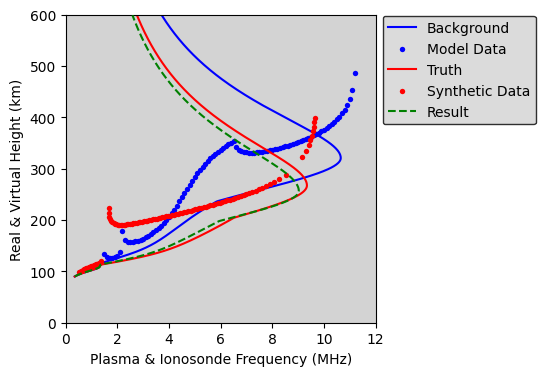

In [5]:
# Plot the results.
# The electron density profile (EDP) is converted from plasma density to plasma
# frequency and plotted using real altitude on the y-axis.
# Virtual heights for O-mode are plotted with ionosonde frequency on
# the x-axis and virtual height on the y-axis.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 600])
ax.set_xlim([0, 12])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(EDP_back) / 1e6,
        input_example['alt'], c='blue', label='Background', zorder=1)
ax.scatter(input_example['freq'], vh_back, c='blue', label='Model Data',
           zorder=1, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_truth) / 1e6,
        input_example['alt'], c='red', label='Truth', zorder=2)
ax.scatter(freq_in, vh_in, c='red', label='Synthetic Data',
           zorder=2, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_result) / 1e6,
        input_example['alt'], '--', c='green', label='Result', zorder=3)
leg = plt.legend(bbox_to_anchor=(1.0, 1.02), facecolor='lightgray', frameon=True)
leg.get_frame().set_edgecolor('black')
plt.savefig(local_dir + 'Minimization.png', dpi=300, bbox_inches='tight', facecolor='white')

NameError: name 'rays' is not defined

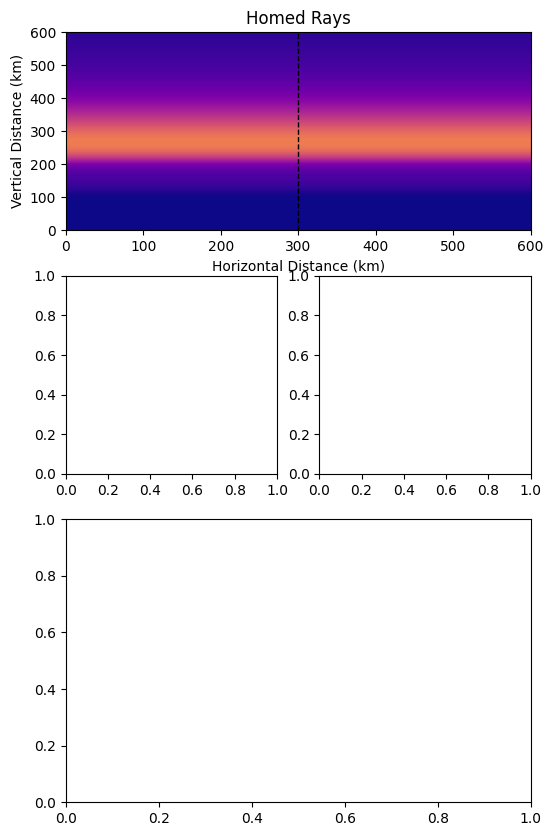

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np

fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[0.7, 0.7, 1], width_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_mid1 = fig.add_subplot(gs[1, 0])
ax_mid2 = fig.add_subplot(gs[1, 1])
ax_bot = fig.add_subplot(gs[2, :])

# --- Top: Raytracing plot ------------------------------------------------
ax_plot = ax_top
ax_plot.set_xlim(0, 600)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
ax_plot.set_title("Homed Rays")

vmin, vmax = 0, 1.6e12
nx = 500
xmax = 1000.
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
pc = ax_plot.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.axvline(x=300, linestyle='--', color='black', linewidth=1)

cmap = cm.plasma
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax_plot.plot(rays[ifr, 0, :], rays[ifr, 1, :], color=color, linewidth=0.5)
ax_plot.text(0.93, 0.95, '(a)', transform=ax_plot.transAxes,
             ha='left', va='top', c='white')

# --- Bottom left: Synthetic Oblique -------------------------------------
ax = ax_mid1
ax.set_title('Synthetic Oblique')
ax.set_facecolor('lightgray')
ax.set_ylabel('Group Path (km)')
ax.set_xlabel('Oblique Frequency (MHz)')
ax.set_xlim([0, 15])
ax.set_ylim([500, 1000])
f = af0_Hz / 1e6
P = agroup_path_homed
ax.scatter(f, P, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax.scatter(f[ifr], P[ifr], color=color, s=5)
ax.text(0.88, 0.95, '(b)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Bottom right: Midpoint Vertical ------------------------------------
ax = ax_mid2
ax.set_title('Midpoint Vertical')
ax.set_facecolor('lightgray')
ax.set_ylabel('Virtual Height (km)')
ax.set_xlabel('Vertical Frequency (MHz)')
ax.set_xlim([0, 15])
ax.set_ylim([0, 400])
freq_vertical_mhz, height_virtual_km = PyRayHF.library.oblique_to_vertical(
    R_loc, agroup_path_homed, f)
freq_vertical_mhz_den = PyRayHF.library.freq2den(freq_vertical_mhz * 1e6)
ax.scatter(freq_vertical_mhz, height_virtual_km, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(freq_vertical_mhz_den[ifr]))
    ax.scatter(freq_vertical_mhz[ifr], height_virtual_km[ifr], color=color, s=5)
ax.text(0.88, 0.95, '(c)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Single shared vertical colorbar on the right ------------------------
cbar_ax = fig.add_axes([0.94, 0.59, 0.02, 0.33])  # x, y, width, height
cbar = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Electron Density (m$^{-3}$)')
cbar.set_ticks(np.arange(vmin, vmax + 2e11, 2e11))

ax = ax_bot
ax.set_title('Minimization')
ax.set_ylim([0, 600])
ax.set_xlim([0, 12])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(EDP_back) / 1e6,
        input_example['alt'], c='blue', label='Background', zorder=1)
ax.scatter(input_example['freq'], vh_back, c='blue', label='Model Data',
           zorder=1, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_truth) / 1e6,
        input_example['alt'], c='red', label='Truth', zorder=2)
ax.scatter(input_example['freq'], vh_data, c='red', label='Synthetic Data',
           zorder=2, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_result) / 1e6,
        input_example['alt'], '--', c='green', label='Result', zorder=3)
leg = plt.legend(bbox_to_anchor=(1.0, 1.02), facecolor='lightgray', frameon=True)
leg.get_frame().set_edgecolor('black')

plt.tight_layout()  # leave space for colorbar
plt.savefig('../figures/Minimization.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


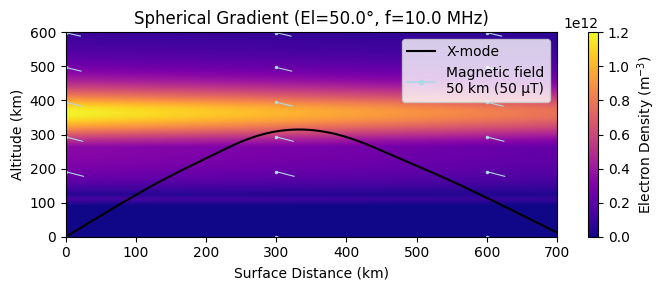

--------------------------------------------------
Spherical Gradient Raytracing X-mode:
--------------------------------------------------
Group Path (km):  983.5315368033675
Group delay (sec):  0.0037466059016084217
Ground Range (km):  712.183537305216
x midpoint (km):  347.42334442582245
z midpoint (km):  313.5739078807892


In [ ]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PyRayHF.library import constants
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_mup_function
from PyRayHF.library import build_refractive_index_interpolator_spherical
from PyRayHF.library import trace_ray_spherical_gradient
import time

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# Add some gradient to it
Ne_gradient = Ne_grid * (1.0 - 0.5 * (Xg / Xg.max()))

# Calculate plasma parameters
X = find_X(Ne_gradient, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)

# X-mode
mode = "X"
mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)

# Build a function for spherical interpolation of mup
mup_func_spherical = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="spherical")

# Build interpolator from spherical μ grid
n_and_grad_spherical = build_refractive_index_interpolator_spherical(z_grid,
                                                                     x_grid,
                                                                     mu)

# Raytrace
result_X = trace_ray_spherical_gradient(n_and_grad_rphi=n_and_grad_spherical,
                                        x0_km=0.0,
                                        z0_km=0.0,
                                        elevation_deg=elevation_deg,
                                        s_max_km=4000.,
                                        mup_func=mup_func_spherical)

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_xlim(0, 700)
ax.set_ylim(0, 600)
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Surface Distance (km)')

# --- Electron density background
vmin, vmax = 0, 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax.pcolormesh(Xg, Zg, Ne_gradient, shading='auto',
                   cmap='plasma', vmin=vmin, vmax=vmax)

# --- Magnetic field visualization (simple line segments with dots)
# Babs is in Tesla (≈3–6e-5), convert to relative visual length
B_scale = 1e6  # empirical scaling factor to make lines a few tens of km long
Bx = Babs * np.sin(np.deg2rad(bpsi)) * B_scale
Bz = -Babs * np.cos(np.deg2rad(bpsi)) * B_scale

# Subsample altitudes for clarity
step_z = max(1, len(alt_km)//5)
z_sample = alt_km[::step_z]
Bx_sample = Bx[::step_z]
Bz_sample = Bz[::step_z]

# Repeat horizontally every 300 km
x_spacing = 300  # km
x_repeat = np.arange(0, ax.get_xlim()[1], x_spacing)

for x_offset in x_repeat:
    for zs, bx, bz in zip(z_sample, Bx_sample, Bz_sample):
        xs, xe = x_offset, x_offset + bx
        ze = zs + bz
        ax.plot([xs, xe], [zs, ze], color='lightblue', lw=0.8)
        ax.plot(xs, zs, 'o', color='lightblue', ms=1.5)

# --- Plot the actual ray paths
line_X, = ax.plot(result_X['x'], result_X['z'], c='black', lw=1.5, label='X-mode')

# --- Add custom magnetic field legend handle
B_ref = 50e-6  # 50 µT reference
line_length_km = B_ref * B_scale  # visible line length
legend_line = Line2D([0, 1], [0, 0], color='lightblue', lw=1.2,
                     marker='o', markersize=3,
                     label=f'Magnetic field\n{line_length_km:.0f} km (50 µT)')

# --- Labels, colorbar, legend
ax.set_title(f"Spherical Gradient (El={elevation_deg:.1f}°, f={f0_Hz/1e6:.1f} MHz)")
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax, ticks=color_ticks)

ax.legend(handles=[line_X, legend_line], loc='upper right')

plt.tight_layout()
plt.savefig(local_dir + 'Spherical_Gradient.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


print('--------------------------------------------------')
print('Spherical Gradient Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_X['group_path_km'])
print('Group delay (sec): ', result_X['group_delay_sec'])
print('Ground Range (km): ', result_X['ground_range_km'])
print('x midpoint (km): ', result_X['x_midpoint'])
print('z midpoint (km): ', result_X['z_midpoint'])
